Make the CIV plot, but this time also include the 388/8403 color-selected that overlapped with the LOFAR footprint (Shimwell+2019).

Note that we need to divide our EW values by 1+z to match Amy's

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
%matplotlib inline
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
import sys 
sys.path.append("/Users/trevormccaffrey/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

In [3]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1638*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label="VLA Detections")

In [4]:
SFR_L14(radluminosity(1.4, 3., 22.5, -0.7, 1.65))

304.40201626385607

----

Load in data for 50 VLA objects.  Going to need the following:

- 3-GHz flux densities (they're 1.4-GHz for the two FIRST sources) to be converted to $L_\mathrm{3GHz}$
- $M_i(z=2)$ for the one Harris SFR relation
- EW for the other SFR relation
- C$_\mathrm{IV}$ EW/blueshift to place the quasars in that space

In [5]:
vla = pd.read_csv("../SpringFinalFigs_moreParams.csv")
vla.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,ICA_CIV_EQW_new2021,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721,CIV_DIST_041921,CIV_DIST_FINAL
0,0,0,0,0,0,0,0,0,0,0,...,35.900650,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.506315,2.792875,0.663044
1,1,1,1,1,1,1,1,1,1,1,...,33.912371,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.618358,2.230519,0.542859
2,2,2,2,2,2,2,2,2,2,2,...,34.648832,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.734290,2.304035,0.560806
3,3,3,3,3,3,3,3,3,3,3,...,43.720855,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.685961,2.164442,0.536310
4,4,4,4,4,4,4,4,4,4,4,...,36.524054,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.312861,2.652129,0.636723


In [6]:
S3 = vla[["int_flux"]].values.flatten()
z_vla = vla[["redshift_1"]].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
det_vla = (vla[["detection"]].values.flatten()==1)
D_vla = vla[["detection"]].values.flatten() + vla[['FIRST']].values.astype("int").flatten()
ew_vla_old = vla[["ICA_CIV_EQW"]].values.flatten() / (1+z_vla)
ew_vla = vla[["ICA_CIV_EQW_new2021"]].values.flatten()
voff_vla = vla[["ICA_CIV_BLUESHIFT"]].values.flatten()
Mi_vla = vla[["MI_Z2_1"]].values.flatten()
SFRavg_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.

#Eq 4 from QLF paper Richards+2006; subtract 7 to convert erg/s to Watts
d = 3.08e19 # 10pc in cm
logL2500_vla = -0.4 * (Mi_vla + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.

R_vla = (10.**L3)/(10.**logL2500_vla)
logR_vla = np.log10(R_vla)

RL_vla = (logR_vla>1)

#Compare with catalog values to see what's going on
voff_cat = vla[["VOFF_CIV_PEAK_1"]].values.flatten()
ew_cat = vla[["EW_CIV_1"]].values.flatten()

#Look at the colors too
del_gi_vla = vla[["DELTA_G_I"]].values.flatten()

Now load in parent sample that is in LOFAR footprint

In [7]:
lofar = pd.read_csv("LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("name", inplace=True)
GOOD = lofar[["good"]].values.flatten()
lofar_det = pd.read_csv("LOFAR_from8403colorselected_detections123_1arcsec.csv")
lofar_det.sort_values("name", inplace=True)
lofar_det.head()

,col1,name,RA_1,Dec_1,Source_Name,RA_2,E_RA,E_RA_tot,DEC_2,E_DEC,...,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id,Separation
15,2206,105245.64+463831.2,163.190206,46.642011,ILTJ105245.70+463830.7,163.190427,0.362932,0.375567,46.641878,0.244608,...,0.540513,106.081950,17.744264,106.081950,17.744264,0.066047,S,P3Hetdex16,5113,0.727160
3,1830,110039.04+510902.3,165.162686,51.150642,ILTJ110039.05+510902.2,165.162688,0.136256,0.156984,51.150616,0.144476,...,0.317960,20.380242,55.903120,20.380242,55.903120,0.067429,S,P4Hetdex16,2296,0.093947
16,2208,110429.51+481637.7,166.122993,48.277147,ILTJ110429.52+481638.0,166.123006,0.435098,0.477744,48.277241,0.259278,...,0.608496,93.276007,21.126713,0.000000,21.126713,0.054989,S,P6,2649,0.341448
4,1832,110853.98+522337.9,167.224924,52.393875,ILTJ110853.96+522337.6,167.224854,0.486835,0.516670,52.393796,0.299093,...,0.700402,84.536970,24.364421,0.000000,24.364421,0.075898,S,P8Hetdex,4605,0.324757
116,8286,111026.20+502403.6,167.609208,50.401021,ILTJ111026.21+502403.8,167.609224,0.490326,0.528534,50.401070,0.292486,...,0.683511,96.225524,27.350117,0.000000,27.350117,0.062552,S,P6,734,0.181365


In [8]:
name = lofar[["name"]].values.flatten() #can use this to pick out detections from Amy's file
name_det = lofar_det[["name"]].values.flatten()
D_lofar = np.array([])
for i in range(len(name)):
    if (name[i]==name_det).any():
        D_lofar = np.append(D_lofar, True)
    else:
        D_lofar = np.append(D_lofar, False)

det_lofar = (D_lofar==1.)

In [9]:
(det_lofar).sum()

123

Good, we have a mask for all the detections in LOFAR

In [10]:
S144 = 210.*np.ones(len(lofar)) #initialize all objects to non-detections
S144[det_lofar] = lofar_det[["Total_flux"]].values.flatten() * 1.e3
z_lofar = lofar[["z_paul"]].values.flatten()
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar[["CIV_EW"]].values.flatten()
voff_lofar = lofar[["CIV_blue"]].values.flatten()
good = (GOOD&(ew_lofar<120)) #don't want to include obj far from distribution in CIV distance calculation
Mi_lofar = lofar[["MI_Z2"]].values.flatten()

#Eq 4 from QLF paper Richards+2006; subtract 7 to convert erg/s to Watts
d = 3.08e19 # 10pc in cm
logL2500_lofar = -0.4 * (Mi_lofar + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.

R_lofar = (10.**L3_lofar)/(10.**logL2500_lofar)
logR_lofar = np.log10(R_lofar)

RL_lofar = (logR_lofar>1)

del_gi_lof = lofar[["DELTA_G_I"]].values.flatten()

In [11]:
!ls /Users/trevormccaffrey/Desktop/git/CIV_Distance/data/

LOFAR_from8403colorselected_all388_CIV.csv
LOFAR_from8403colorselected_detections123_1arcsec.csv
RM_CIV_bestFitLine_noScale.npy
bestfit.npy
const_civdist_arrs


In [13]:
#The best-fit RM line updated 4/19/2021
fit_old = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/RM_CIV_bestFitLine_noScale.npy")[65000:,:]
fit = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/bestfit.npy")
fit.shape

(52920, 2)

In [14]:
#4/13/2021: Gordon asks: How does detection fraction change as a function of CIV distance if we exclude object
#                        with Delta(g-i)>~0.3?
red_vla = (del_gi_vla > 0.3)
red_lof = (del_gi_lof > 0.3)

In [16]:
data_vla = np.array([voff_vla, np.log10(ew_vla)]).T
data_lofar = np.array([voff_lofar, np.log10(ew_lofar)]).T

#Compute CIV distances
vla_dist = CIV_distance(data_vla, fit, step=10, path="/Users/trevormccaffrey/Desktop/git/CIV_Distance/")
lof_dist = CIV_distance(data_lofar, fit, step=10, path="/Users/trevormccaffrey/Desktop/git/CIV_Distance/")

#CIV distance == 0 will indicate reconstructions Amy has classified as "bad"
#make sure these aren't included in the "low" CIV bin
lofar_dist = np.ones(len(lofar))
lofar_dist[good] = lof_dist.flatten()

#### I decided to keep objects with "bad" reconstructions

In [17]:
vla["CIV_DIST_FINAL"] = vla_dist
vla.to_csv("../SpringFinalFigs_moreParams.csv")
lofar["CIV_DIST_FINAL"] = lof_dist
lofar.to_csv("LOFAR_from8403colorselected_all388_CIV.csv")

In [18]:
vla_dist = vla[["CIV_DIST_FINAL"]].values.flatten() 
lof_dist = lofar[["CIV_DIST_FINAL"]].values.flatten()

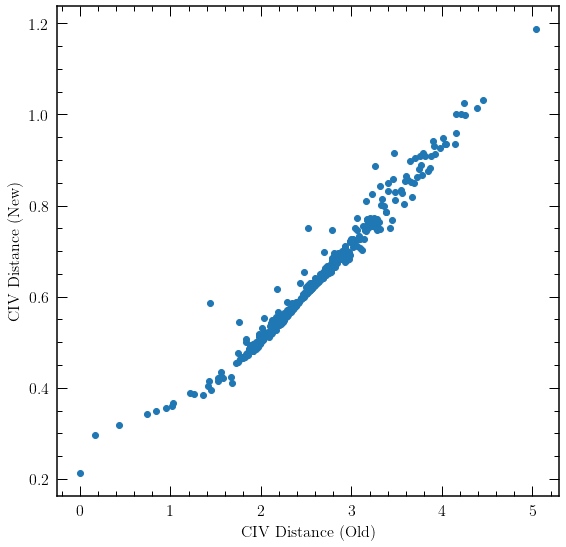

In [19]:
#Compare new and old CIV distances
plt.figure(figsize=(9,9))
plt.scatter(lofar[["CIV_DIST_041921"]].values.flatten(), lof_dist)
plt.xlabel("CIV Distance (Old)")
plt.ylabel("CIV Distance (New)")
plt.savefig("/Users/trevormccaffrey/Desktop/newcivdist210730_vs_oldcivdist210419.png")
plt.show()

Old values were 2.0 and 3.2

We have three regions of CIV space:

- High EW  in rest-frame translates to >54Å --- CIV dist < 0.48
- Moderate EW/blueshift --- 0.48 < CIV < 0.75
- High blueshift (defined by the 6 highest-blueshift VLA sources) --- CIV dist > 0.75

In [122]:
low = 0.5
high = 0.75

In [123]:
lofar_low = ((lof_dist<low)).flatten()
lofar_mid = ((lof_dist>low)&(lof_dist<high)).flatten()
lofar_high = (lof_dist>high).flatten()
lofar_low.sum(), lofar_mid.sum(), lofar_high.sum()

(53, 264, 71)

In [124]:
print("High-blueshift/low-EW detection fraction = ", (det_lofar&lofar_high).sum() / lofar_high.sum())
print("Mid-blueshift/EW detection fraction      = ", (det_lofar&lofar_mid).sum() / lofar_mid.sum())
print("Low-blueshift/High EW detection fraction = ", (det_lofar&lofar_low).sum() / lofar_low.sum())

High-blueshift/low-EW detection fraction =  0.49295774647887325
Mid-blueshift/EW detection fraction      =  0.24621212121212122
Low-blueshift/High EW detection fraction =  0.4339622641509434


In [125]:
vla_low = (vla_dist<low).flatten()
vla_mid = ((vla_dist>low)&(vla_dist<high)).flatten()
vla_high = (vla_dist>high).flatten()
vla_low.sum(), vla_mid.sum(), vla_high.sum()

(10, 33, 7)

In [73]:
CIV_dist = np.concatenate((vla_dist, lof_dist))
det_mask = np.concatenate((det_vla, det_lofar))
#first_mask = np.concatenate((D_vla==2, first_lofar))
RL_mask  = np.concatenate((RL_vla, RL_lofar))

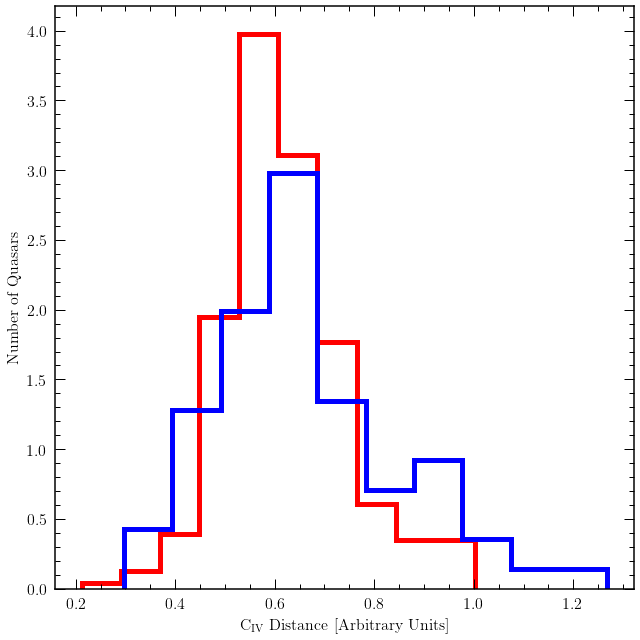

In [74]:
fig = plt.figure(figsize=(9,9))

plt.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
plt.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)

plt.xlabel("C$_\mathrm{IV}$ Distance [Arbitrary Units]")
plt.ylabel("Number of Quasars")
plt.tight_layout()
plt.savefig("CIVdist_histogram.pdf")
plt.show()

In [75]:
CIVdet = np.array([CIV_dist.flatten(), det_mask]).T
CIVdet[:5,:]

array([[0.66280125, 1.        ],
       [0.54254457, 1.        ],
       [0.56069364, 0.        ],
       [0.53634426, 0.        ],
       [0.63630793, 0.        ]])

In [76]:
#Want a FIRST mask for all sources.


In [77]:
#Make sure the sorting is uniform; it should already be, but MAKE SURE!
CIVsort = CIVdet[CIVdet[:,0].argsort()]
RLsort = RL_mask[CIVdet[:,0].argsort()]

In [78]:
CIVlist = np.array([]) #no longer have specified intervals of CIV - save what they happen to be here
det_fraction = np.array([])
det_errs = np.array([])

#Initialize counts in each bin
total = 0
det = 0
binsize = 63 #this one is tunable - depends how many quasars are being considered 

for j in range(len(CIVsort)):
    total += 1
    if CIVsort[j,1]:
        det += 1
    if total >= binsize:
        det_fraction = np.append(det_fraction, det/total)
        det_errs = np.append(det_errs, (det**0.5)/total) #save 1-sigma Poisson errors
        CIVlist = np.append(CIVlist, CIVsort[j-binsize//2,0]) #Save the distance at the midpoint of each bin
        print("%d/%d, %.2f" % (det, total, CIVsort[j-binsize//2,0]))

        #Moving on to next bin, so restart the counts
        det = 0
        total = 0 

#Don't need these if no leftover objects (i.e. equal-sized bins)
det_fraction = np.append(det_fraction, det/total)
det_errs = np.append(det_errs, (det**0.5)/total)
CIVlist = np.append(CIVlist, CIVsort[j-5,0])

print("%d/%d, %.2f" % (det, total, CIVsort[j,0]))
det = 0
total = 0

28/63, 0.47
14/63, 0.53
12/63, 0.57
21/63, 0.61
18/63, 0.66
20/63, 0.73
32/60, 1.27


Text(0.5, 0, 'C$_\\mathrm{IV}$ Distance [Scaled Units]')

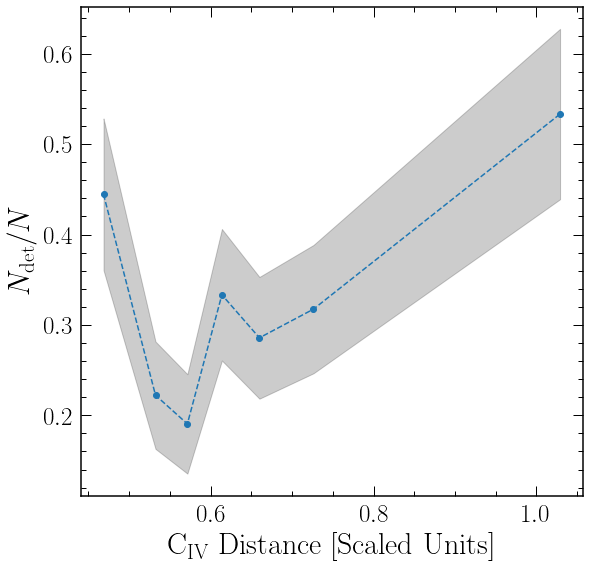

In [79]:
from scipy import interpolate

x = np.arange(min(CIVlist), max(CIVlist), 0.0001)
fp = interpolate.interp1d(CIVlist, det_fraction+det_errs, kind="slinear")
fpp = fp(x)
fm = interpolate.interp1d(CIVlist, det_fraction-det_errs, kind="slinear")
fmm = fm(x)

plt.figure(figsize=(9,9))

plt.plot(CIVlist, det_fraction, "--o")
plt.fill_between(x, fmm, fpp, alpha=0.2, color="k")

plt.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("$N_\mathrm{det}/N$", fontsize=30)
plt.xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=30)

In [80]:
det_fraction

array([0.44444444, 0.22222222, 0.19047619, 0.33333333, 0.28571429,
       0.31746032, 0.53333333])

In [81]:
voff = np.concatenate((voff_vla, voff_lofar))
ew = np.concatenate((ew_vla, ew_lofar))
D = np.concatenate((det_vla, det_lofar))

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


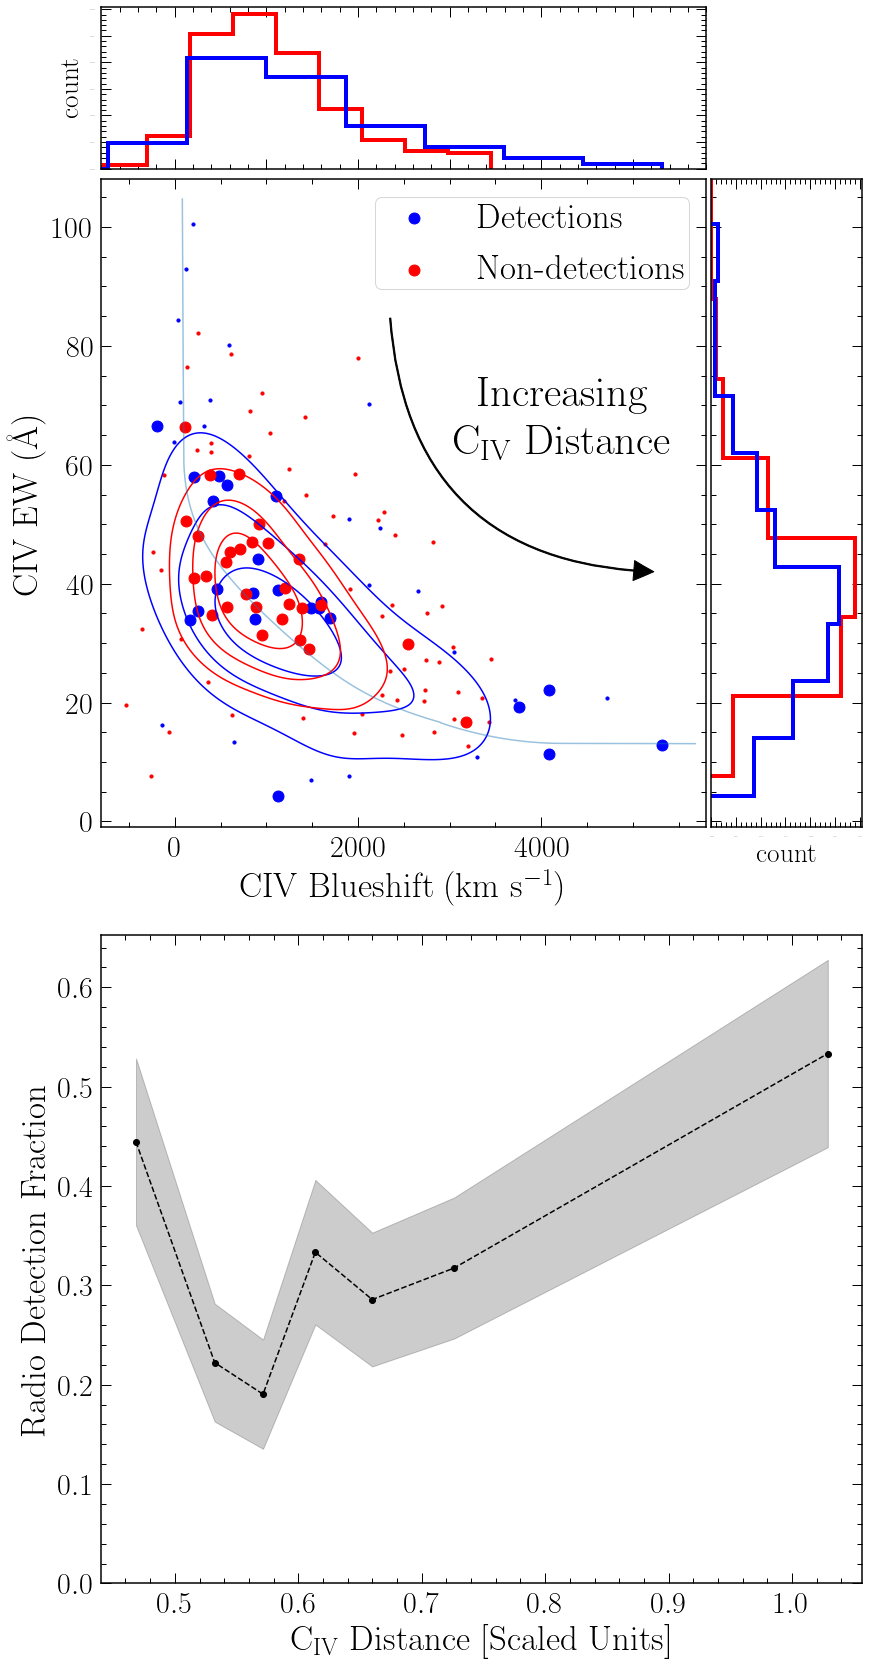

In [88]:
import matplotlib.patches as patches

#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.4, 0.3
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.075]
rect_histy = [left + width + spacing, bottom, 0.15, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(14, 30))


ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

#Plot the best-fit line
ax_scatter.plot(fit[10000:51500,0], 10**fit[10000:51500,1], alpha=0.45)

#Plot scatter data
plot_contour(voff_lofar[det_lofar], ew_lofar[det_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar], ew_lofar[~det_lofar], c="red", nlevels=3, ax=plt.gca())

plt.scatter(voff_vla[det_vla], ew_vla[det_vla], color="b", s=120, label="Detections")
plt.scatter(voff_vla[~det_vla], ew_vla[~det_vla], color="r", s=120, label="Non-detections")


xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True)
ax_histx.hist(voff[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True, orientation='horizontal')
ax_histy.hist(ew[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True, orientation='horizontal')
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("CIV EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 35}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((2350, 85), (5250, 42),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=3300,y=70,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=3035,y=62,s="C$_\mathrm{IV}$ Distance", fontsize=42.5)


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")

#Add another axis for the second panel that we want to include
rect_err = [left, 0.05, width+0.155, height]
ax_err = plt.axes(rect_err)
ax_err.tick_params(direction='in', top=True, right=True)

err_region = True #Activate for err_region -- deactivate for simpler CIV histogram

if err_region:
    ax_err.plot(CIVlist, det_fraction, "--o", color="k")
    ax_err.fill_between(x, fmm, fpp, alpha=0.2, color="k")
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_ylabel("Radio Detection Fraction", fontsize=35)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylim(0.0, ax_err.get_ylim()[1])
    
else:
    ax_err.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
    ax_err.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylabel("Number of Quasars", fontsize=35)
    
    
plt.tight_layout()
plt.savefig("CIV_wLOFARcontours_whistos_wDetfraction.pdf")
plt.show()

(array([[  0.,   2.,  10.,  21.,  10.,   1.,   1.,   2.,   2.,   1.],
        [  3.,  15.,  60., 142.,  88.,  43.,  29.,   7.,   0.,   1.]]),
 array([0.21182326, 0.31748262, 0.42314197, 0.52880133, 0.63446068,
        0.74012004, 0.8457794 , 0.95143875, 1.05709811, 1.16275746,
        1.26841682]),
 <a list of 2 List[Polygon] objects>)

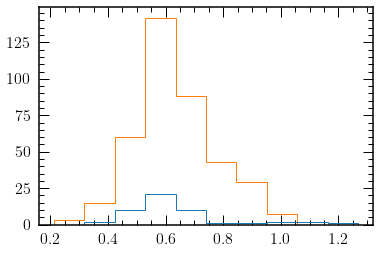

In [89]:
plt.hist([vla_dist, lof_dist], histtype="step")

In [90]:
fit.shape

(52920, 2)

In [91]:
CIV_low = ((CIVdet[:,0]<low)).flatten() #"bad" reconstructions are labeled with CIV=0
CIV_mid = ((CIVdet[:,0]>low)&(CIVdet[:,0]<high)).flatten()
CIV_high = (CIVdet[:,0]>high).flatten()
CIV_det = CIVdet[:,1]==1
#CIV_low.sum(), CIV_mid.sum(), CIV_high.sum()

In [92]:
CIV_det.sum()

145

In [214]:
len(CIVdet)

438

In [224]:
print("FINAL DETECTION FRACTIONS")

print("LOFAR Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_lofar.sum(), len(det_lofar), det_lofar.sum()/len(det_lofar), (det_lofar.sum())**0.5/len(det_lofar)))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_high).sum(), \
                                                                  lofar_high.sum(), \
                                                                  (det_lofar&lofar_high).sum() / lofar_high.sum(), \
                                                                  ((det_lofar&lofar_high).sum())**0.5/lofar_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_mid).sum(), \
                                                                  lofar_mid.sum(), \
                                                                  (det_lofar&lofar_mid).sum() / lofar_mid.sum(), \
                                                                  ((det_lofar&lofar_mid).sum())**0.5/lofar_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_low).sum(), \
                                                                  lofar_low.sum(), \
                                                                  (det_lofar&lofar_low).sum() / lofar_low.sum(), \
                                                                  ((det_lofar&lofar_low).sum())**0.5/lofar_low.sum()))

print("\nVLA Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_vla.sum(), len(det_vla), det_vla.sum()/len(det_vla), (det_vla.sum())**0.5/len(det_vla)))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_high).sum(), \
                                                                  vla_high.sum(), \
                                                                  (det_vla&vla_high).sum() / vla_high.sum(), \
                                                                  ((det_vla&vla_high).sum())**0.5/vla_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_mid).sum(), \
                                                                  vla_mid.sum(), \
                                                                  (det_vla&vla_mid).sum() / vla_mid.sum(), \
                                                                  ((det_vla&vla_mid).sum())**0.5/vla_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_low).sum(), \
                                                                  vla_low.sum(), \
                                                                  (det_vla&vla_low).sum() / vla_low.sum(), \
                                                                  ((det_vla&vla_low).sum())**0.5/vla_low.sum()))

print("\nCombined - All %d Objects" % (CIV_high.sum()+CIV_mid.sum()+CIV_low.sum()))
print("Total = %2d/%-5d = %7.4f±%.4f" % (CIVdet[:,1].sum(), len(CIVdet), CIVdet[:,1].sum()/len(CIVdet), ((CIVdet[:,1]).sum())**0.5/len(CIVdet)))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_high).sum(), \
                                                                  CIV_high.sum(), \
                                                                  (CIV_det&CIV_high).sum() / CIV_high.sum(), \
                                                                  ((CIV_det&CIV_high).sum())**0.5/CIV_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_mid).sum(), \
                                                                  CIV_mid.sum(), \
                                                                  (CIV_det&CIV_mid).sum() / CIV_mid.sum(), \
                                                                  ((CIV_det&CIV_mid).sum())**0.5/CIV_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_low).sum(), \
                                                                  CIV_low.sum(), \
                                                                  (CIV_det&CIV_low).sum() / CIV_low.sum(), \
                                                                  ((CIV_det&CIV_low).sum())**0.5/CIV_low.sum()))

FINAL DETECTION FRACTIONS
LOFAR Objects
Total = 123/388   =  0.3170±0.0286
High-blueshift/low-EW detection fraction = 35/71    =  0.4930±0.0833
Mid-blueshift/EW detection fraction      = 65/264   =  0.2462±0.0305
Low-blueshift/High EW detection fraction = 23/53    =  0.4340±0.0905

VLA Objects
Total = 22/50    =  0.4400±0.0938
High-blueshift/low-EW detection fraction =  5/7     =  0.7143±0.3194
Mid-blueshift/EW detection fraction      = 12/33    =  0.3636±0.1050
Low-blueshift/High EW detection fraction =  5/10    =  0.5000±0.2236

Combined - All 438 Objects
Total = 145/438   =  0.3311±0.0275
High-blueshift/low-EW detection fraction = 40/78    =  0.5128±0.0811
Mid-blueshift/EW detection fraction      = 77/297   =  0.2593±0.0295
Low-blueshift/High EW detection fraction = 28/63    =  0.4444±0.0840


Now the $\Delta(g-i)<0.3$ objects

In [206]:
red_all = np.concatenate((red_vla, red_lof))

In [232]:
print("FINAL DETECTION FRACTIONS -- ∆(g-i)<0.3:\n")

print("LOFAR Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_lofar[~red_lof].sum(), len(det_lofar[~red_lof]), det_lofar[~red_lof].sum()/len(det_lofar[~red_lof]), (det_lofar[~red_lof].sum())**0.5/len(det_lofar[~red_lof])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_high&(~red_lof)).sum(), \
                                                                  (lofar_high&(~red_lof)).sum(), \
                                                                  (det_lofar&lofar_high&(~red_lof)).sum() / (lofar_high&(~red_lof)).sum(), \
                                                                  ((det_lofar&lofar_high&(~red_lof)).sum())**0.5/(lofar_high&(~red_lof)).sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_mid&(~red_lof)).sum(), \
                                                                  (lofar_mid&(~red_lof)).sum(), \
                                                                  (det_lofar&lofar_mid&(~red_lof)).sum() / (lofar_mid&(~red_lof)).sum(), \
                                                                  ((det_lofar&lofar_mid&(~red_lof)).sum())**0.5/(lofar_mid&(~red_lof)).sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_low&(~red_lof)).sum(), \
                                                                  (lofar_low&(~red_lof)).sum(), \
                                                                  (det_lofar&lofar_low&(~red_lof)).sum() / (lofar_low&(~red_lof)).sum(), \
                                                                  ((det_lofar&lofar_low).sum())**0.5/(lofar_low&(~red_lof)).sum()))
print("\nVLA Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_vla[~red_vla].sum(), len(det_vla[~red_vla]), det_vla[~red_vla].sum()/len(det_vla[~red_vla]), (det_vla[~red_vla].sum())**0.5/len(det_vla[~red_vla])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_high&(~red_vla)).sum(), \
                                                                  (vla_high&(~red_vla)).sum(), \
                                                                  (det_vla&vla_high&(~red_vla)).sum() / (vla_high&(~red_vla)).sum(), \
                                                                  ((det_vla&vla_high&(~red_vla)).sum())**0.5/(vla_high&(~red_vla)).sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_mid).sum(), \
                                                                  (vla_mid&(~red_vla)).sum(), \
                                                                  (det_vla&vla_mid&(~red_vla)).sum() / (vla_mid&(~red_vla)).sum(), \
                                                                  ((det_vla&vla_mid&(~red_vla)).sum())**0.5/(vla_mid&(~red_vla)).sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_low&(~red_vla)).sum(), \
                                                                  (vla_low&(~red_vla)).sum(), \
                                                                  (det_vla&vla_low&(~red_vla)).sum() / (vla_low&(~red_vla)).sum(), \
                                                                  ((det_vla&vla_low&(~red_vla)).sum())**0.5/(vla_low&(~red_vla)).sum()))

print("\nCombined - All %d Objects" % (CIV_high.sum()+CIV_mid.sum()+CIV_low.sum()-red_all.sum()))
print("Total = %2d/%-5d = %7.4f±%.4f" % (CIVdet[~red_all,1].sum(), len(CIVdet[~red_all,1]), CIVdet[~red_all,1].sum()/len(CIVdet[~red_all,1]), ((CIVdet[~red_all,1]).sum())**0.5/len(CIVdet[~red_all,1])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_high&(~red_all)).sum(), \
                                                                  (CIV_high&(~red_all)).sum(), \
                                                                  (CIV_det&CIV_high&(~red_all)).sum() / (CIV_high&(~red_all)).sum(), \
                                                                  ((CIV_det&CIV_high&(~red_all)).sum())**0.5/(CIV_high&(~red_all)).sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_mid&(~red_all)).sum(), \
                                                                  (CIV_mid&(~red_all)).sum(), \
                                                                  (CIV_det&CIV_mid&(~red_all)).sum() / (CIV_mid&(~red_all)).sum(), \
                                                                  ((CIV_det&CIV_mid&(~red_all)).sum())**0.5/(CIV_mid&(~red_all)).sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_low&(~red_all)).sum(), \
                                                                  (CIV_low&(~red_all)).sum(), \
                                                                  (CIV_det&CIV_low&(~red_all)).sum() / (CIV_low&(~red_all)).sum(), \
                                                                  ((CIV_det&CIV_low&(~red_all)).sum())**0.5/(CIV_low&(~red_all)).sum()))

FINAL DETECTION FRACTIONS -- ∆(g-i)<0.3:

LOFAR Objects
Total = 110/364   =  0.3022±0.0288
High-blueshift/low-EW detection fraction = 34/68    =  0.5000±0.0857
Mid-blueshift/EW detection fraction      = 57/247   =  0.2308±0.0306
Low-blueshift/High EW detection fraction = 19/49    =  0.3878±0.0979

VLA Objects
Total = 20/47    =  0.4255±0.0952
High-blueshift/low-EW detection fraction =  4/6     =  0.6667±0.3333
Mid-blueshift/EW detection fraction      = 12/31    =  0.3548±0.1070
Low-blueshift/High EW detection fraction =  5/10    =  0.5000±0.2236

Combined - All 411 Objects
Total = 130/411   =  0.3163±0.0277
High-blueshift/low-EW detection fraction = 38/74    =  0.5135±0.0833
Mid-blueshift/EW detection fraction      = 68/278   =  0.2446±0.0297
Low-blueshift/High EW detection fraction = 24/59    =  0.4068±0.0830


Why is total detection number for VLA one off?

In [204]:
CIV_low.shape, vla_low.shape, lofar_low.shape

((438,), (50,), (388,))

In [130]:
first = pd.read_csv("lofar_first_quasars.csv")
first.head()

,RA_1,DEC_1,SIDEPROB,FPEAK,FINT,RMS,MAJOR,MINOR,POSANG,FITTED_MAJOR,...,RA_2,Dec_2,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME,Separation_Amy,Separation
0,212.054182,56.225684,0.014053,282.30,293.109560,0.143229,1.22,0.87,84.7,5.54,...,212.053970,56.225695,0.007200,1609.041849,13.840797,True,2.02400,140812.95+561332.5,0.007200,0.426382
1,201.711404,56.172357,0.014053,1.81,1.566346,0.155822,1.06,0.00,28.9,5.50,...,201.711296,56.172255,0.016432,525.950246,28.560380,True,1.86913,132650.71+561020.1,0.016432,0.434270
2,198.743400,56.061674,0.014053,271.10,277.786160,0.251901,1.08,0.53,9.5,5.51,...,198.743352,56.061806,0.010049,323.743288,66.444175,True,1.74740,131458.40+560342.5,0.010049,0.488401
3,193.606333,55.821999,0.014053,1.55,1.204231,0.134370,0.71,0.00,165.1,5.45,...,193.606360,55.821915,0.090921,392.351647,45.808092,True,1.81910,125425.52+554918.9,0.000547,0.303061
4,171.085679,55.182034,0.014053,3.65,3.413823,0.133159,1.09,0.00,48.7,5.51,...,171.085884,55.182005,0.017951,-205.576865,43.377951,True,1.97138,112420.61+551055.2,0.017951,0.417741


In [131]:
#Want a mask that picks out FIRST detections from our LOFAR sources
lof = lofar[["name"]].values.flatten()
fir = first[["name"]].values.flatten()
lof.sort(), fir.sort()
lofar_1st = np.array([])

for i in range(len(lof)):
    if (lof[i]==fir).any():
        lofar_1st = np.append(lofar_1st, True)
    else:
        lofar_1st = np.append(lofar_1st, False)

first_lofar = (lofar_1st==1.)

In [132]:
lof, fir

(array(['104446.00+521742.8', '104547.58+551853.8', '104718.64+541917.8',
        '104829.97+550819.0', '104852.00+530747.2', '104855.21+504845.4',
        '104908.78+542526.8', '105002.65+512729.5', '105031.03+483845.1',
        '105053.91+531131.9', '105119.30+510544.9', '105150.54+522847.2',
        '105221.77+555253.5', '105245.64+463831.2', '105454.16+503123.9',
        '105521.98+463303.7', '105546.18+503959.7', '105636.09+501749.4',
        '105636.40+493156.4', '105649.64+493414.2', '105656.09+471613.5',
        '105724.15+503523.6', '105730.79+521104.9', '105732.69+470612.0',
        '105743.12+532231.4', '105747.40+545935.1', '105827.99+505700.9',
        '110039.04+510902.3', '110429.51+481637.7', '110449.58+552133.6',
        '110553.74+532038.4', '110626.66+484707.1', '110643.99+494152.0',
        '110803.06+520315.0', '110852.80+511934.1', '110853.98+522337.9',
        '110920.87+545234.2', '110924.71+530359.8', '110939.35+464349.7',
        '111015.30+530331.3', '111026.

In [133]:
first_lofar.sum(), (first_lofar&det_lofar).sum()

(38, 26)

In [234]:
first_vla = (D_vla==2).copy()
first_mask = np.concatenate((D_vla==2, first_lofar))

In [236]:
print("FINAL DETECTION FRACTIONS -- FIRST Detections Removed\n")

print("LOFAR Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_lofar[~first_lofar].sum(), len(det_lofar[~first_lofar]), det_lofar[~first_lofar].sum()/len(det_lofar[~first_lofar]), (det_lofar[~first_lofar].sum())**0.5/len(det_lofar[~first_lofar])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_high&~first_lofar).sum(), \
                                                                  lofar_high[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_high&~first_lofar).sum() / lofar_high[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_high&~first_lofar).sum())**0.5/lofar_high[~first_lofar].sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_mid&~first_lofar).sum(), \
                                                                  lofar_mid[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_mid&~first_lofar).sum() / lofar_mid[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_mid&~first_lofar).sum())**0.5/lofar_mid[~first_lofar].sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_low&~first_lofar).sum(), \
                                                                  lofar_low[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_low&~first_lofar).sum() / lofar_low[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_low&~first_lofar).sum())**0.5/lofar_low[~first_lofar].sum()))

print("\nVLA Objects")
print("Total = %2d/%-5d = %7.4f±%.4f" % (det_vla[~first_vla].sum(), len(det_vla[~first_vla]), det_vla[~first_vla].sum()/len(det_vla[~first_vla]), (det_vla[~first_vla].sum())**0.5/len(det_vla[~first_vla])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_high&(D_vla!=2)).sum(), \
                                                                  vla_high[(D_vla!=2)].sum(), \
                                                                  (det_vla&vla_high&(D_vla!=2)).sum() / vla_high[(D_vla!=2)].sum(), \
                                                                  ((det_vla&vla_high&(D_vla!=2)).sum())**0.5/vla_high[(D_vla!=2)].sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_mid&(D_vla!=2)).sum(), \
                                                                  vla_mid[(D_vla!=2)].sum(), \
                                                                  (det_vla&vla_mid&(D_vla!=2)).sum() / vla_mid[(D_vla!=2)].sum(), \
                                                                  ((det_vla&vla_mid&(D_vla!=2)).sum())**0.5/vla_mid[(D_vla!=2)].sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_low&(D_vla!=2)).sum(), \
                                                                  vla_low[(D_vla!=2)].sum(), \
                                                                  (det_vla&vla_low&(D_vla!=2)).sum() / vla_low[(D_vla!=2)].sum(), \
                                                                  ((det_vla&vla_low&(D_vla!=2)).sum())**0.5/vla_low[(D_vla!=2)].sum()))

print("\nCombined - All %d Objects" % (CIV_high[~first_mask].sum()+CIV_mid[~first_mask].sum()+CIV_low[~first_mask].sum()))
print("Total = %2d/%-5d = %7.4f±%.4f" % (CIVdet[~first_mask,1].sum(), len(CIVdet[~first_mask,1]), CIVdet[~first_mask,1].sum()/len(CIVdet[~first_mask,1]), ((CIVdet[~first_mask,1]).sum())**0.5/len(CIVdet[~first_mask,1])))
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_high&~first_mask).sum(), \
                                                                  CIV_high[~first_mask].sum(), \
                                                                  (CIV_det&CIV_high&~first_mask).sum() / CIV_high[~first_mask].sum(), \
                                                                  ((CIV_det&CIV_high&~first_mask).sum())**0.5/CIV_high[~first_mask].sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_mid&~first_mask).sum(), \
                                                                  CIV_mid[~first_mask].sum(), \
                                                                  (CIV_det&CIV_mid&~first_mask).sum() / CIV_mid[~first_mask].sum(), \
                                                                  ((CIV_det&CIV_mid&~first_mask).sum())**0.5/CIV_mid[~first_mask].sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_low&~first_mask).sum(), \
                                                                  CIV_low[~first_mask].sum(), \
                                                                  (CIV_det&CIV_low&~first_mask).sum() / CIV_low[~first_mask].sum(), \
                                                                  ((CIV_det&CIV_low&~first_mask).sum())**0.5/CIV_low[~first_mask].sum()))

FINAL DETECTION FRACTIONS -- FIRST Detections Removed

LOFAR Objects
Total = 97/350   =  0.2771±0.0281
High-blueshift/low-EW detection fraction = 28/62    =  0.4516±0.0853
Mid-blueshift/EW detection fraction      = 53/242   =  0.2190±0.0301
Low-blueshift/High EW detection fraction = 16/46    =  0.3478±0.0870

VLA Objects
Total = 20/48    =  0.4167±0.0932
High-blueshift/low-EW detection fraction =  4/6     =  0.6667±0.3333
Mid-blueshift/EW detection fraction      = 11/32    =  0.3438±0.1036
Low-blueshift/High EW detection fraction =  5/10    =  0.5000±0.2236

Combined - All 398 Objects
Total = 117/398   =  0.2940±0.0272
High-blueshift/low-EW detection fraction = 32/68    =  0.4706±0.0832
Mid-blueshift/EW detection fraction      = 64/274   =  0.2336±0.0292
Low-blueshift/High EW detection fraction = 21/56    =  0.3750±0.0818


So there are now 388 - 38 = 350 objects from LOFAR with the FIRST sources removed.  

- High CIV distance: 6/8 detected by LOFAR
- **Mid CIV distance: 13/23 detected by LOFAR**
- Low CIV distance: 7/7 detected by LOFAR

---

Include the FIRST sources in the CIV plot

Also include the Nyland+ 2020 quasars with newly launched jets

In [139]:
nyland = pd.read_csv("../Nyland_CIV.csv")
ew_nyland   = nyland[["EW_CIV"]].values.flatten()
voff_nyland = nyland[["VOFF_CIV_PEAK"]].values.flatten()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


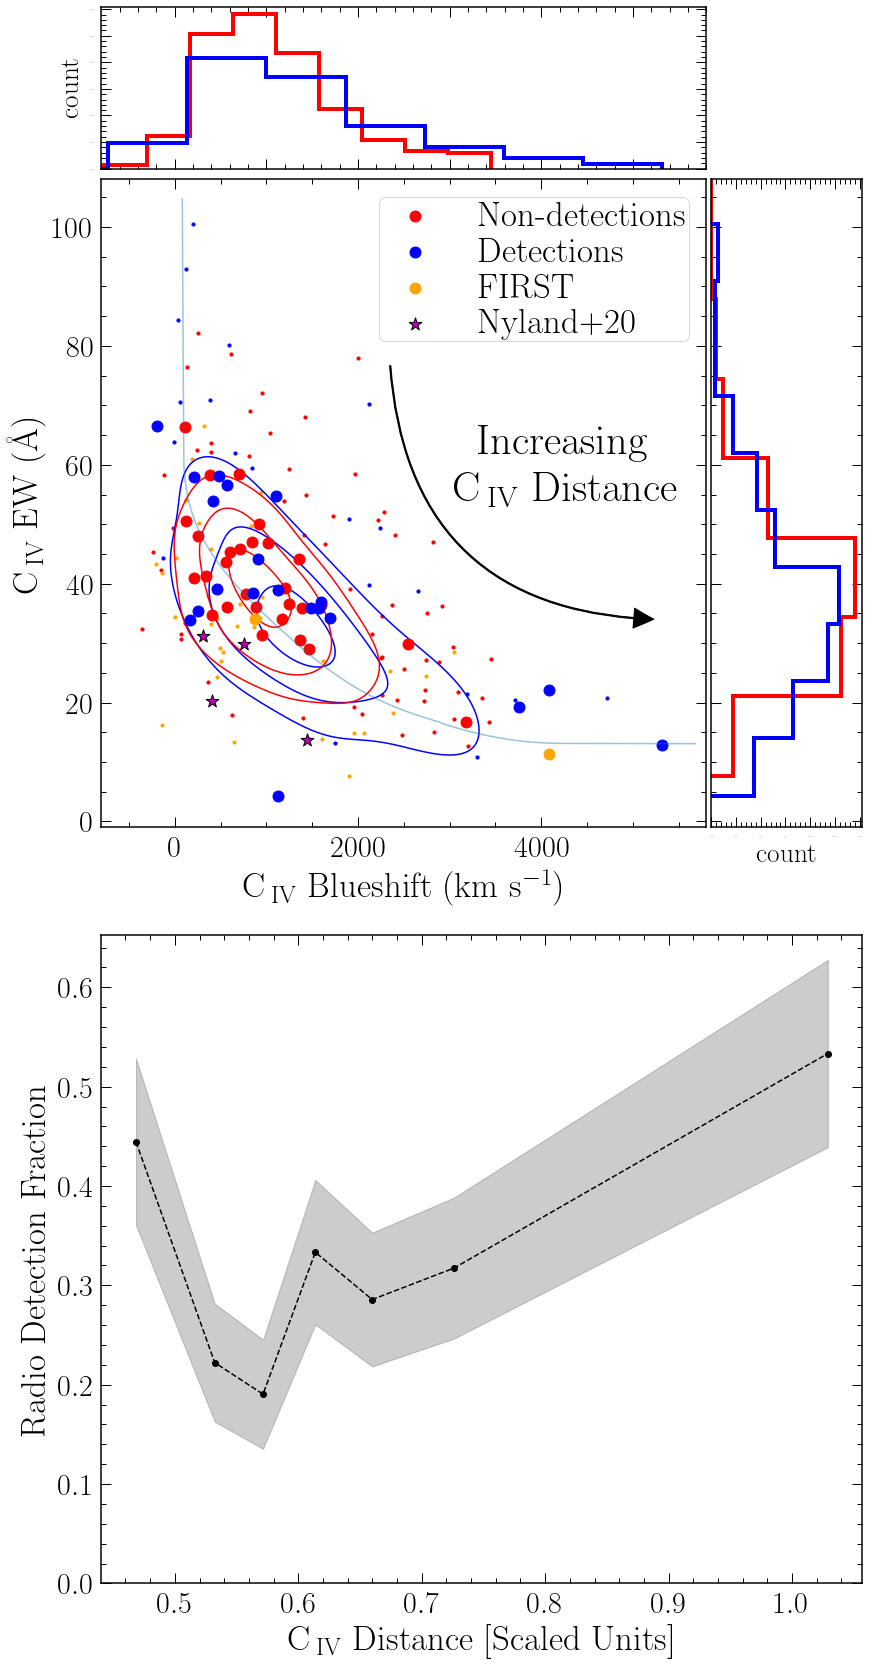

In [140]:
import matplotlib.patches as patches

#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.4, 0.3
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.075]
rect_histy = [left + width + spacing, bottom, 0.15, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(14, 30))


ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

#Plot the best-fit line
ax_scatter.plot(fit[10000:51500,0], 10.**fit[10000:51500,1], alpha=0.45)

#Plot scatter data
plot_contour(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], c="red", nlevels=3, ax=plt.gca())
plt.scatter(voff_lofar[first_lofar], ew_lofar[first_lofar], color="orange", s=10)


plt.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], color="r", s=120, label="Non-detections", zorder=2)
plt.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], color="b", s=120, label="Detections", zorder=2)
plt.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], color="orange", s=120, label="FIRST", zorder=2)

#Got Nyland+20 data on 4/12/2021 -- right now it is just catalogued values of 4/6 objects with CIV (only 4 appear in DR7, while all 6 are in DR14 but DR14 doesn't have CIV values)
plt.scatter(voff_nyland, ew_nyland, color="m", edgecolor="k", s=180, marker="*", label="Nyland+20")


xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True)
ax_histx.hist(voff[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True, orientation='horizontal')
ax_histy.hist(ew[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True, orientation='horizontal')
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 35}, borderpad=0.05, labelspacing=0.05)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((2350, 77), (5250, 34),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=3300,y=62,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=3035,y=54,s="C\,$_\mathrm{IV}$ Distance", fontsize=42.5)


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")

#Add another axis for the second panel that we want to include
rect_err = [left, 0.05, width+0.155, height]
ax_err = plt.axes(rect_err)
ax_err.tick_params(direction='in', top=True, right=True)

err_region = True #Activate for err_region -- deactivate for simpler CIV histogram

if err_region:
    ax_err.plot(CIVlist, det_fraction, "--o", color="k")
    ax_err.fill_between(x, fmm, fpp, alpha=0.2, color="k")
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_ylabel("Radio Detection Fraction", fontsize=35)
    ax_err.set_xlabel("C\,$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylim(0.0, ax_err.get_ylim()[1])
    
else:
    ax_err.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
    ax_err.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylabel("Number of Quasars", fontsize=35)
    
    
plt.tight_layout()
#plt.savefig("CIV_wLOFARcontours_whistos_wDetfraction_wFIRST.pdf")
plt.savefig("../PaperPlots/fig5.pdf")
plt.show()

----

Now we want to add some kind of mark on the CIV plot that represents the demarcations we define for different detection fractions.  Will need to:

- An index along the best-fit line corresponding to this CIV distance
- A corrsesponding data point with CIV distance closest to this value
- Then can simply do a linear fit to those two points to create a boundary separating sources above/below the CIV distance value that marks the minimum detection fraction

In [196]:
CIV_0p50 = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.50.npy")
m_50, b_50 = np.polyfit(10.**CIV_0p50[:,1], CIV_0p50[:,0], 1)
x_50 = np.arange(37, 69, 1)

CIV_0p75 = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.75.npy")
m_75, b_75 = np.polyfit(10.**CIV_0p75[:,1], CIV_0p75[:,0], 1)
x_75 = np.arange(2, 40, 1)

y_50 = m_75*x_50 + b_50
y_75 = m_50*x_75 + b_75

In [197]:
#Want to combine the VLA-FIRST and LoTSS-FIRST sources in the marginal distributions below
first_lofar.sum()
voff_first = np.concatenate((voff_lofar[first_lofar], voff_vla[D_vla==2]))
ew_first = np.concatenate((ew_lofar[first_lofar], ew_vla[D_vla==2]))
ew_first.shape

(40,)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


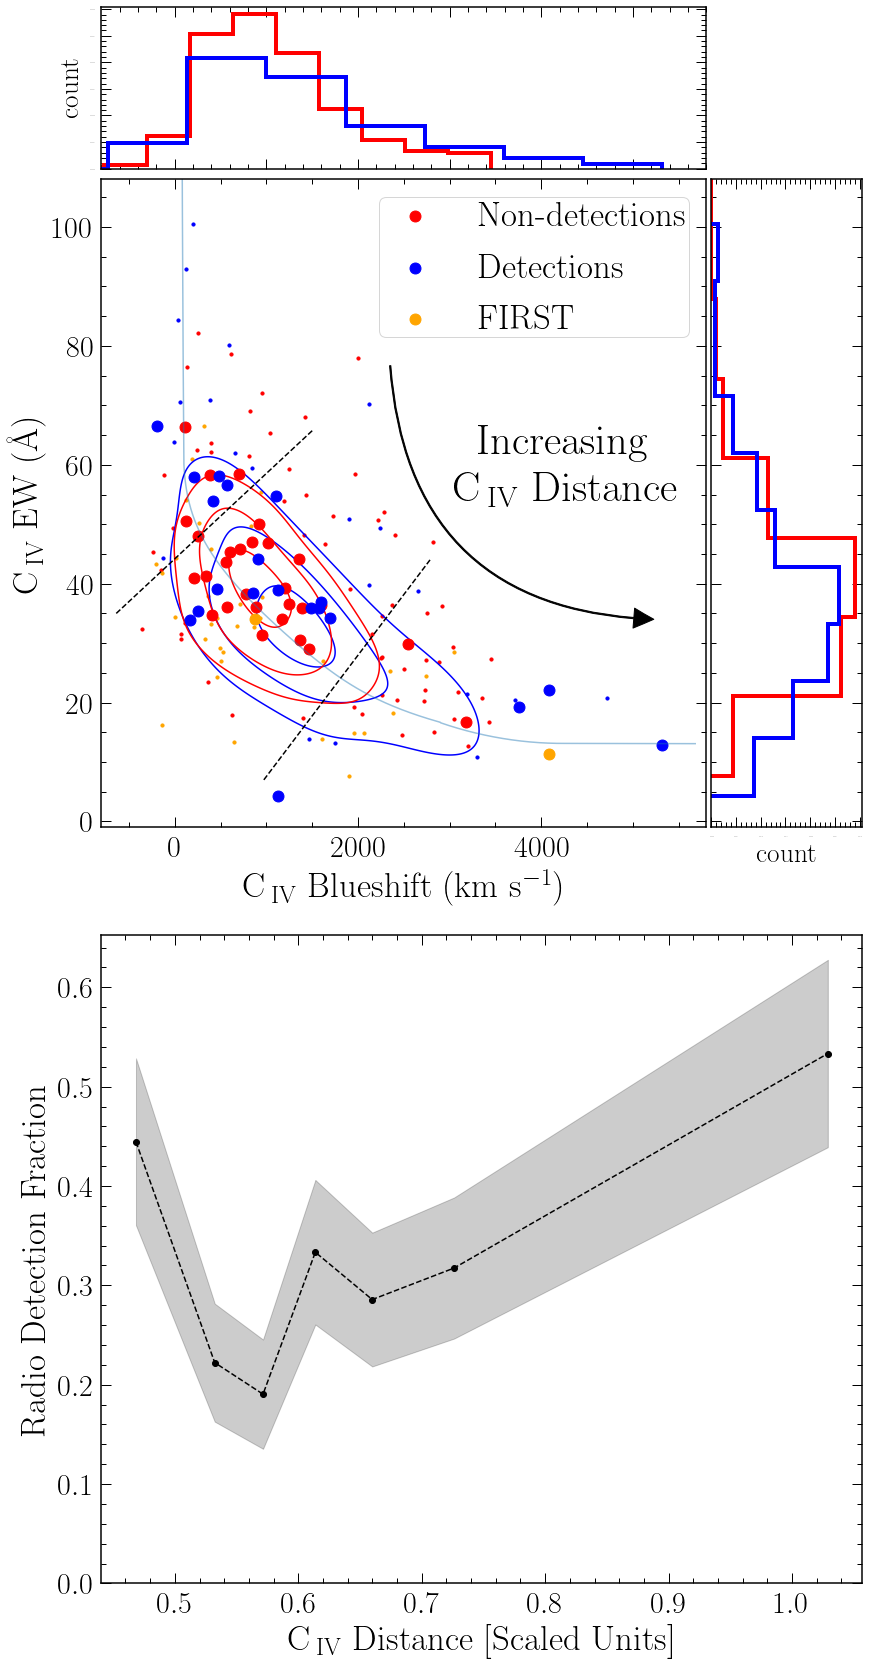

In [200]:
import matplotlib.patches as patches

#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.4, 0.3
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.075]
rect_histy = [left + width + spacing, bottom, 0.15, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(14, 30))


ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

#Plot the best-fit line
ax_scatter.plot(fit[:51500,0], 10.**fit[:51500,1], alpha=0.45)

#Plot scatter data
plot_contour(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], c="red", nlevels=3, ax=plt.gca())
plt.scatter(voff_lofar[first_lofar], ew_lofar[first_lofar], color="orange", s=10)


plt.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], color="r", s=120, label="Non-detections", zorder=2)
plt.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], color="b", s=120, label="Detections", zorder=2)
plt.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], color="orange", s=120, label="FIRST", zorder=2)

#Got Nyland+20 data on 4/12/2021 -- right now it is just catalogued values of 4/6 objects with CIV (only 4 appear in DR7, while all 6 are in DR14 but DR14 doesn't have CIV values)
#plt.scatter(voff_nyland, ew_nyland, color="m", edgecolor="k", s=180, marker="*", label="Nyland+20")


xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True)
ax_histx.hist(voff[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True)
#ax_histx.hist(voff_first,align='mid', histtype="step", linewidth=4.0, ls="-", color="orange", density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True, orientation='horizontal')
ax_histy.hist(ew[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True, orientation='horizontal')
#ax_histy.hist(ew_first,align='mid', histtype="step", linewidth=4.0, ls="-", color="orange", density=True, orientation='horizontal')
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 35}, borderpad=0.05)#, labelspacing=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((2350, 77), (5250, 34),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=3300,y=62,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=3035,y=54,s="C\,$_\mathrm{IV}$ Distance", fontsize=42.5)


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")

#Add another axis for the second panel that we want to include
rect_err = [left, 0.05, width+0.155, height]
ax_err = plt.axes(rect_err)
ax_err.tick_params(direction='in', top=True, right=True)

err_region = True #Activate for err_region -- deactivate for simpler CIV histogram

if err_region:
    ax_err.plot(CIVlist, det_fraction, "--o", color="k")
    ax_err.fill_between(x, fmm, fpp, alpha=0.2, color="k")
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_ylabel("Radio Detection Fraction", fontsize=35)
    ax_err.set_xlabel("C\,$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylim(0.0, ax_err.get_ylim()[1])
    
else:
    ax_err.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
    ax_err.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylabel("Number of Quasars", fontsize=35)
    
ax_scatter.plot(y_50-1200, x_50-2, "--k")
ax_scatter.plot(y_75+900, x_75+5, "--k")

plt.tight_layout()
#plt.savefig("CIV_wLOFARcontours_whistos_wDetfraction_wFIRST.pdf")
plt.savefig("../PaperPlots/fig3new.pdf")
plt.show()

In [201]:
m_50, m_75

(49.011965879588395, 69.58057059784932)